In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sky_spot import utils

sns.set_style('whitegrid')

RESTART_OVERHEAD_HOURS = 0.01

df = pd.read_csv('../../results/greedy-no-overhead/f_vs_gap_two_exp-180.csv')

In [45]:
print(len(df))
df = df.drop_duplicates()
print(len(df))
df.to_csv('../../results/f_vs_gap_two_exp-180.csv', index=False)

1332
1332


In [46]:
groups = [x for _, x in df.groupby(['avg_spot_hours', 'task_duration_hours'])]

result_df = pd.DataFrame(columns=['spot_fraction', 'task_fraction', 'cost_gap'])

for group in groups:
    avg_spot_hours = group['avg_spot_hours'].iloc[0]
    avg_wait_hours = group['avg_wait_hours'].iloc[0]
    spot_fraction = avg_spot_hours / (avg_spot_hours + avg_wait_hours)
    task_fraction = group['task_duration_hours'].iloc[0] / 52
    greedy_cost = group[group['restart_overhead_hours'] > 0]['avg_cost']
    assert len(greedy_cost) == 1, greedy_cost
    greedy_cost = greedy_cost.iloc[0]
    optimal_cost = group[group['restart_overhead_hours'] == 0]['avg_cost']
    assert len(optimal_cost) == 1
    optimal_cost = optimal_cost.iloc[0]
    cost_gap = (greedy_cost - optimal_cost - RESTART_OVERHEAD_HOURS * utils.COSTS[utils.ClusterType.ON_DEMAND]) / optimal_cost
    result_df = pd.concat([result_df, pd.DataFrame.from_records([{
        'spot_fraction': spot_fraction,
        'task_fraction': task_fraction,
        'cost_gap': cost_gap,
    }])])

result_df

,spot_fraction,task_fraction,cost_gap
0,0.247059,0.05288,0.026323
0,0.247059,0.10288,0.027954
0,0.247059,0.15288,0.029892
0,0.247059,0.20288,0.044717
0,0.247059,0.25288,0.093113
...,...,...,...
0,0.992880,0.70288,0.000508
0,0.992880,0.75288,0.000474
0,0.992880,0.80288,0.000444
0,0.992880,0.85288,0.000418


Text(0, 0.5, 'Cost ratio: (Greedy - no_overhead)/no_overhead')

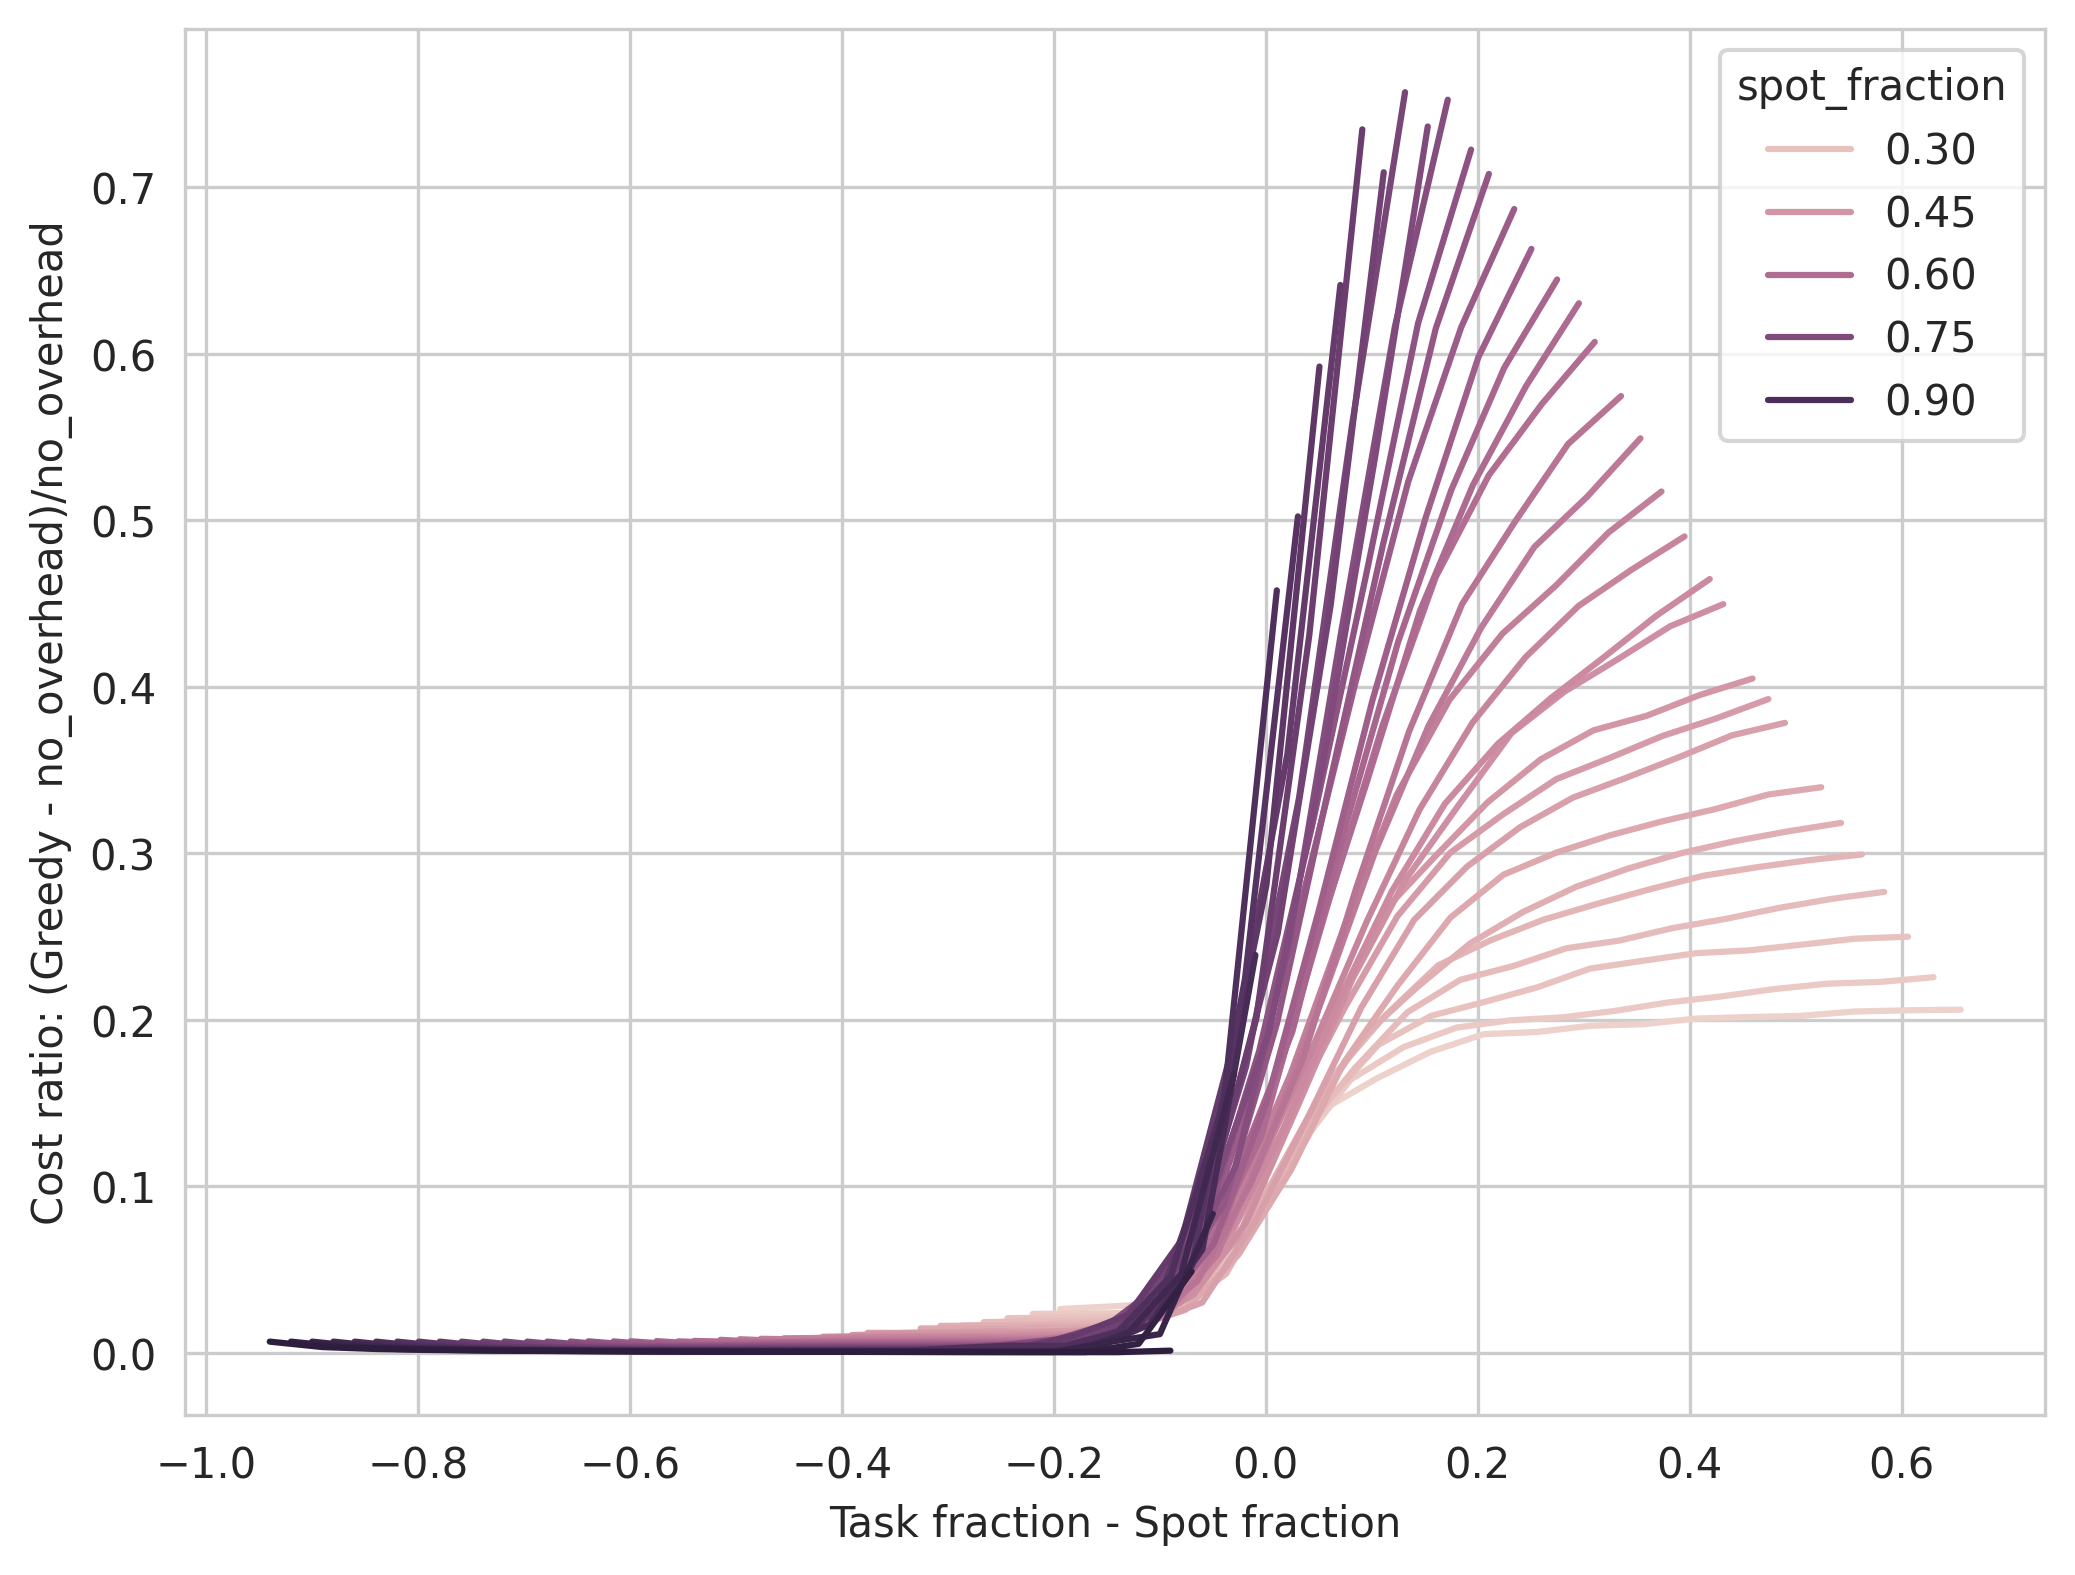

In [47]:
fig = plt.figure(figsize=(8, 6), dpi=300)
ax = fig.add_subplot(111)

x = result_df['task_fraction'] - result_df['spot_fraction']
sns.lineplot(x=x, y=result_df['cost_gap'], hue=result_df['spot_fraction'], ax=ax)
ax.set_xlabel('Task fraction - Spot fraction')
ax.set_ylabel('Cost ratio: (Greedy - no_overhead)/no_overhead')

## Greedy Optimal

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sky_spot import utils

sns.set_style('whitegrid')


RESTART_OVERHEAD_HOURS = 0.4
df = pd.read_csv(f'../../results/greedy-optimal/restart={RESTART_OVERHEAD_HOURS:.2f}/f_vs_gap_two_exp-180.csv')

In [3]:
groups = [x for _, x in df.groupby(['avg_spot_hours', 'task_duration_hours'])]

result_df = pd.DataFrame(
    columns=['spot_fraction', 'task_fraction', 'cost_gap'])

for group in groups:
    avg_spot_hours = group['avg_spot_hours'].iloc[0]
    avg_wait_hours = group['avg_wait_hours'].iloc[0]
    spot_fraction = avg_spot_hours / (avg_spot_hours + avg_wait_hours)
    task_fraction = group['task_duration_hours'].iloc[0] / 52
    greedy_cost = group[group['strategy'] == 'strawman']['avg_cost']
    if len(greedy_cost) == 0:
        continue
    assert len(greedy_cost) == 1, greedy_cost
    greedy_cost = greedy_cost.iloc[0]
    optimal_cost = group[group['strategy'] == 'ideal_ilp_overhead']['avg_cost']
    assert len(optimal_cost) == 1
    optimal_cost = optimal_cost.iloc[0]
    cost_gap = greedy_cost / optimal_cost
    result_df = pd.concat([
        result_df,
        pd.DataFrame.from_records([{
            'spot_fraction': spot_fraction,
            'task_fraction': task_fraction,
            'cost_gap': cost_gap,
        }])
    ], ignore_index=True)

result_df

,spot_fraction,task_fraction,cost_gap
0,0.483871,0.100000,1.314584
1,0.483871,0.200000,1.230838
2,0.483871,0.283871,1.158652
3,0.483871,0.300000,1.153171
4,0.483871,0.308871,1.145039
...,...,...,...
170,0.992880,0.970000,1.133971
171,0.992880,0.978000,1.081178
172,0.992880,0.980000,1.073478
173,0.992880,0.990000,2.169467


     spot_fraction  task_fraction  cost_gap
0         0.483871       0.100000  1.314584
57        0.592357       0.717357  1.255376
93        0.692308       0.842308  1.334144
121       0.791531       0.866531  1.483631
146       0.892437       0.917437  1.551820
173       0.992880       0.990000  2.169467 0     -0.383871
57     0.125000
93     0.150000
121    0.075000
146    0.025000
173   -0.002880
dtype: float64


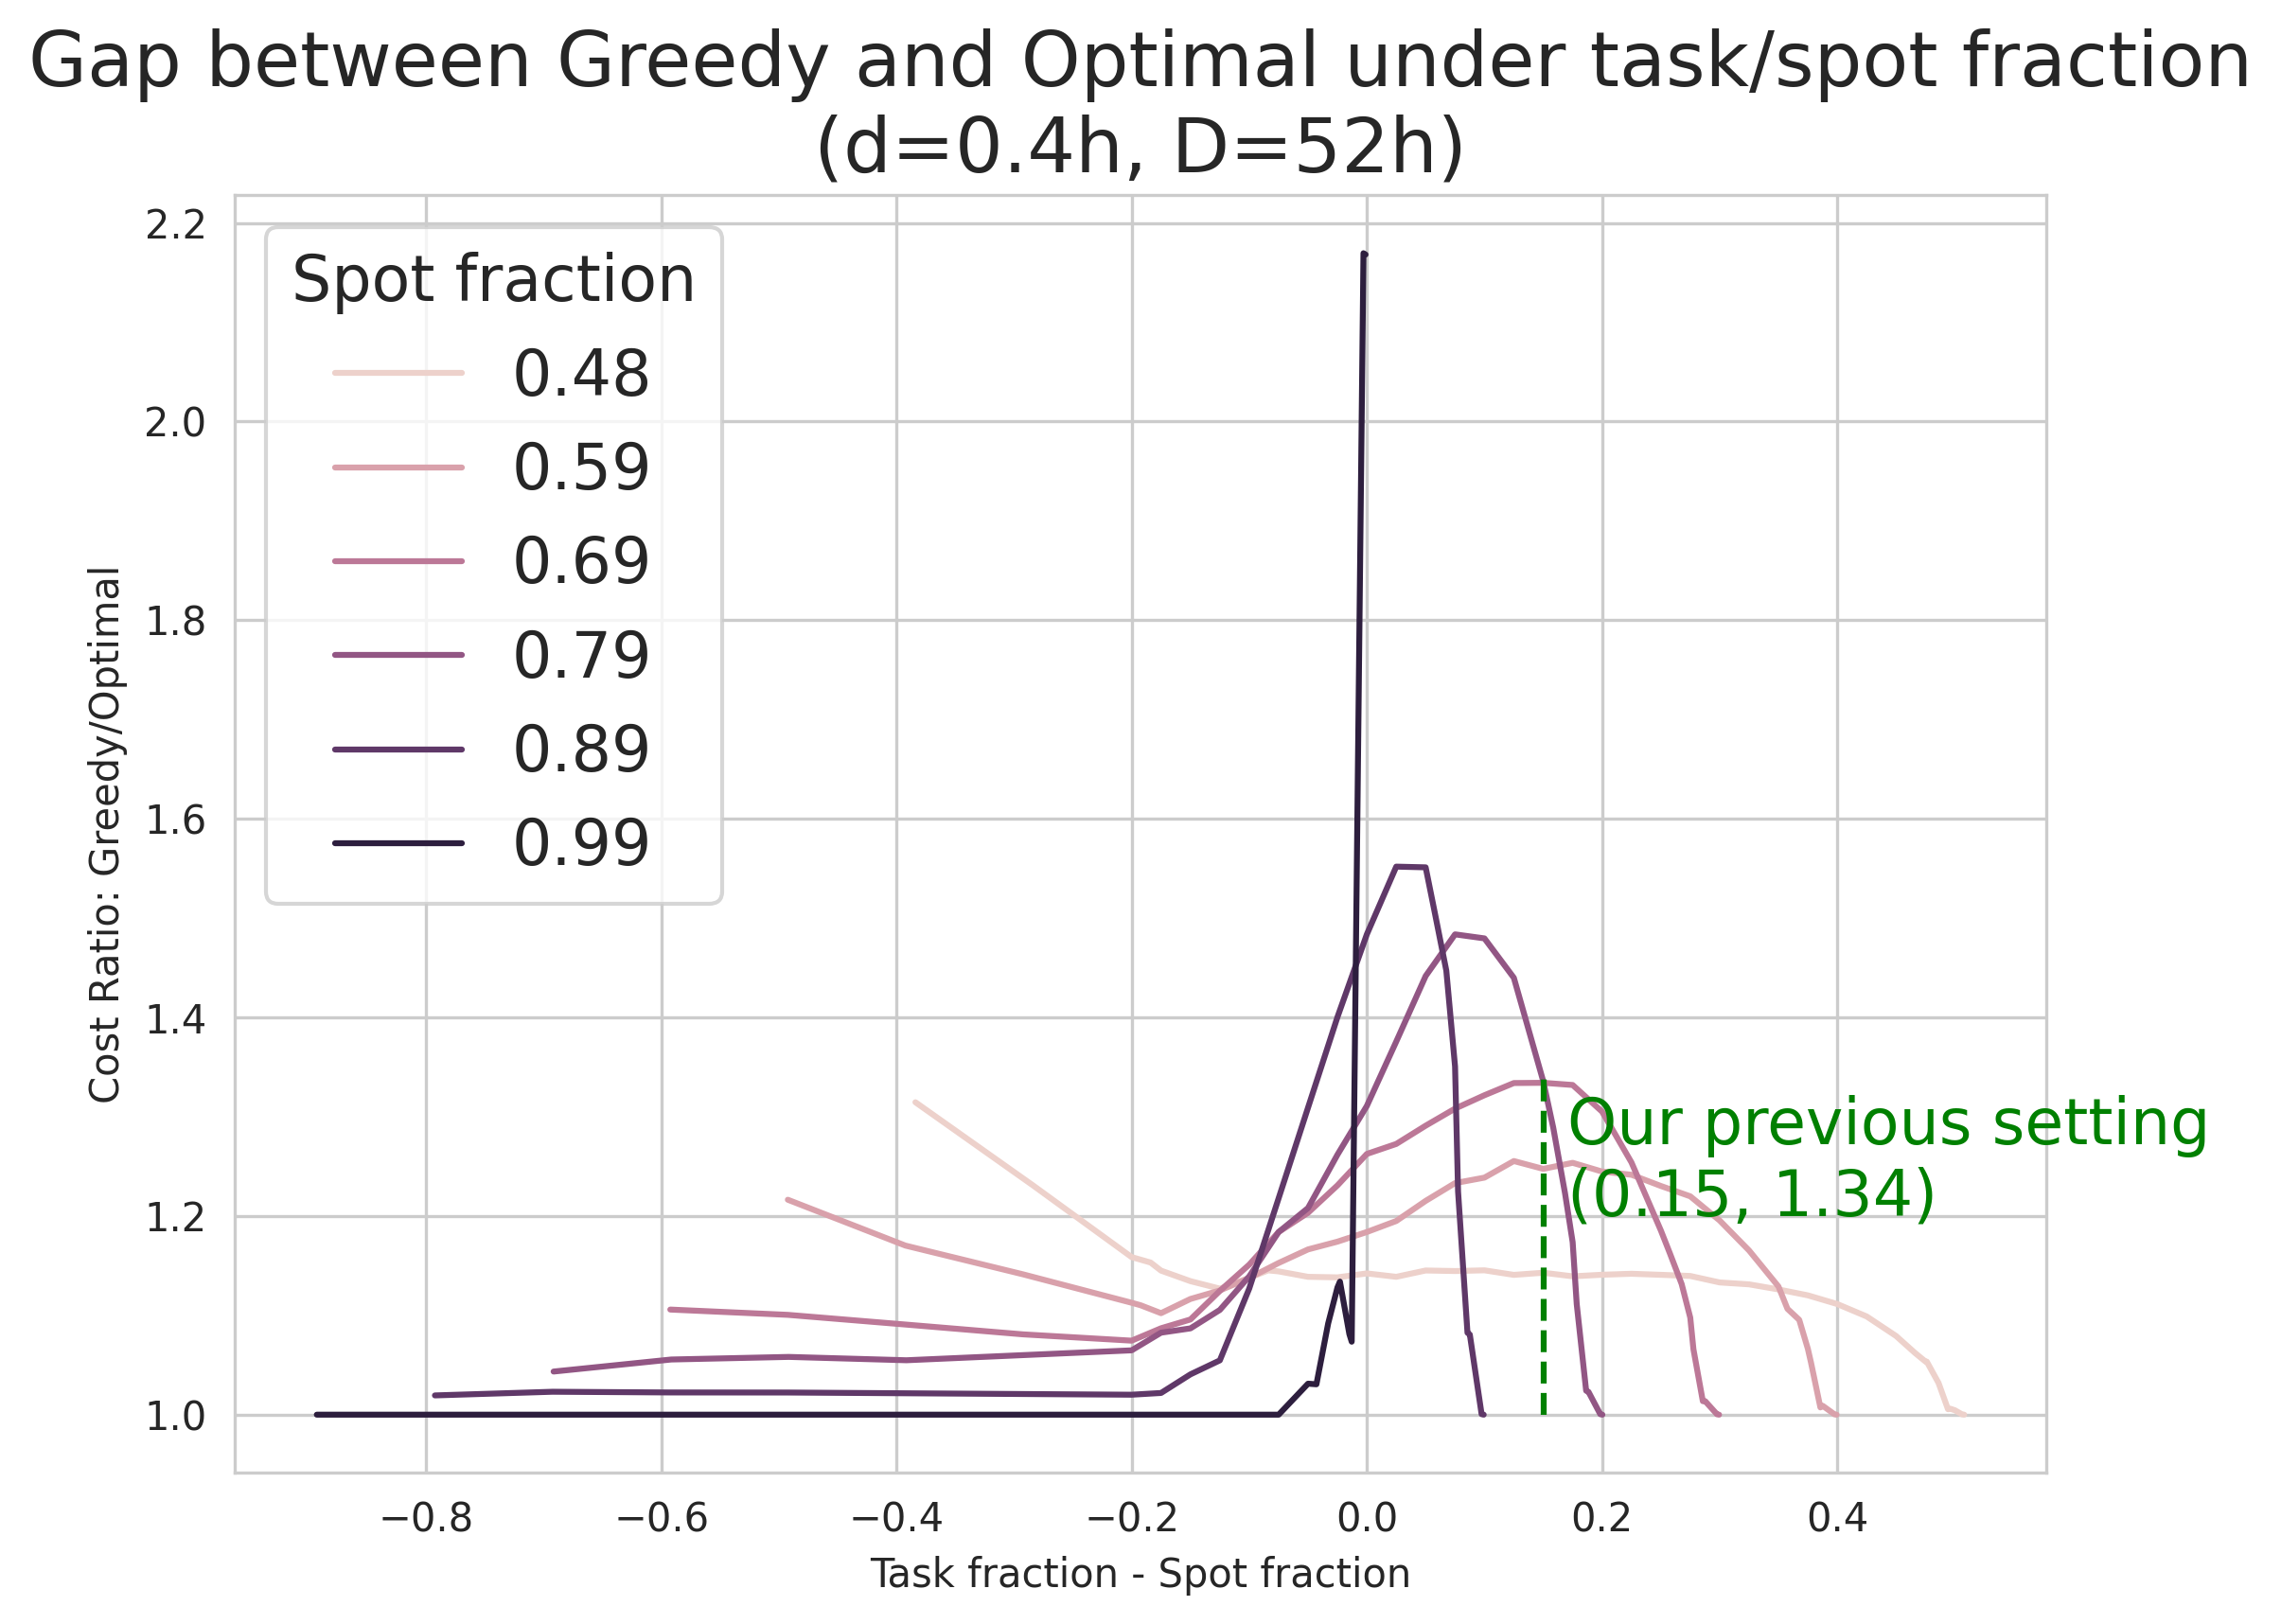

In [4]:
ORIGINAL_GAP_SECONDS = 600
GAP_SECONDS = 180
ORIGINAL_SPOT_GAPS = 24.5 * ORIGINAL_GAP_SECONDS / GAP_SECONDS
ORIGINAL_WAIT_GAPS = 6.4 * ORIGINAL_GAP_SECONDS / GAP_SECONDS

ORIGIN_SPOT_FRACTION = ORIGINAL_SPOT_GAPS / (ORIGINAL_SPOT_GAPS + ORIGINAL_WAIT_GAPS)

TRANSFORM = False
# print(ORIGIN_SPOT_FRACTION)

fig = plt.figure(figsize=(8, 6), dpi=300)
ax = fig.add_subplot(111)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16

def task_spot_ratio(row):
    if TRANSFORM:
        return (row['task_fraction'] - row['spot_fraction']) / (1 - row['spot_fraction'])
    else:
        return (row['task_fraction'] - row['spot_fraction'])
        # return (row['task_fraction'])

x = task_spot_ratio(result_df)
max_cost_gap = result_df.loc[result_df.groupby(['spot_fraction'])['cost_gap'].idxmax()]
print(max_cost_gap, task_spot_ratio(max_cost_gap))
sns.lineplot(x=x,
             y=result_df['cost_gap'],
             hue=result_df['spot_fraction'],
             ax=ax)
if TRANSFORM:
    ax.set_xlabel('(T/D - f) / (1 - f)')
else:
    ax.set_xlabel('Task fraction - Spot fraction')
    # ax.set_xlabel('Task fraction')
ax.set_ylabel('Cost Ratio: Greedy/Optimal')
ax.set_title(f'Gap between Greedy and Optimal under task/spot fraction\n(d={RESTART_OVERHEAD_HOURS}h, D=52h)')
if TRANSFORM:
    ax.vlines(0.5, 1, 2.2, linestyles='dashed', colors='black')
    ax.text(-1, 2.1, '$\\frac{T/D - f}{1-f} \\approx 0.5$')
else:
    setting = 48/52-ORIGIN_SPOT_FRACTION+0.02
    ax.vlines(setting, 1, 1.34, linestyles='dashed', colors='green')
    ax.text(setting+0.02, 1.2, f'Our previous setting\n({setting:.2f}, 1.34)', color='green')
ax.legend(title='Spot fraction', loc='upper left')
leg = ax.get_legend()
for t in leg.texts:
    # truncate label text to 4 characters
    t.set_text(f'{float(t.get_text()):.2f}')
if TRANSFORM:
    ax.set_xlim(-4, 4)
fig.tight_layout()

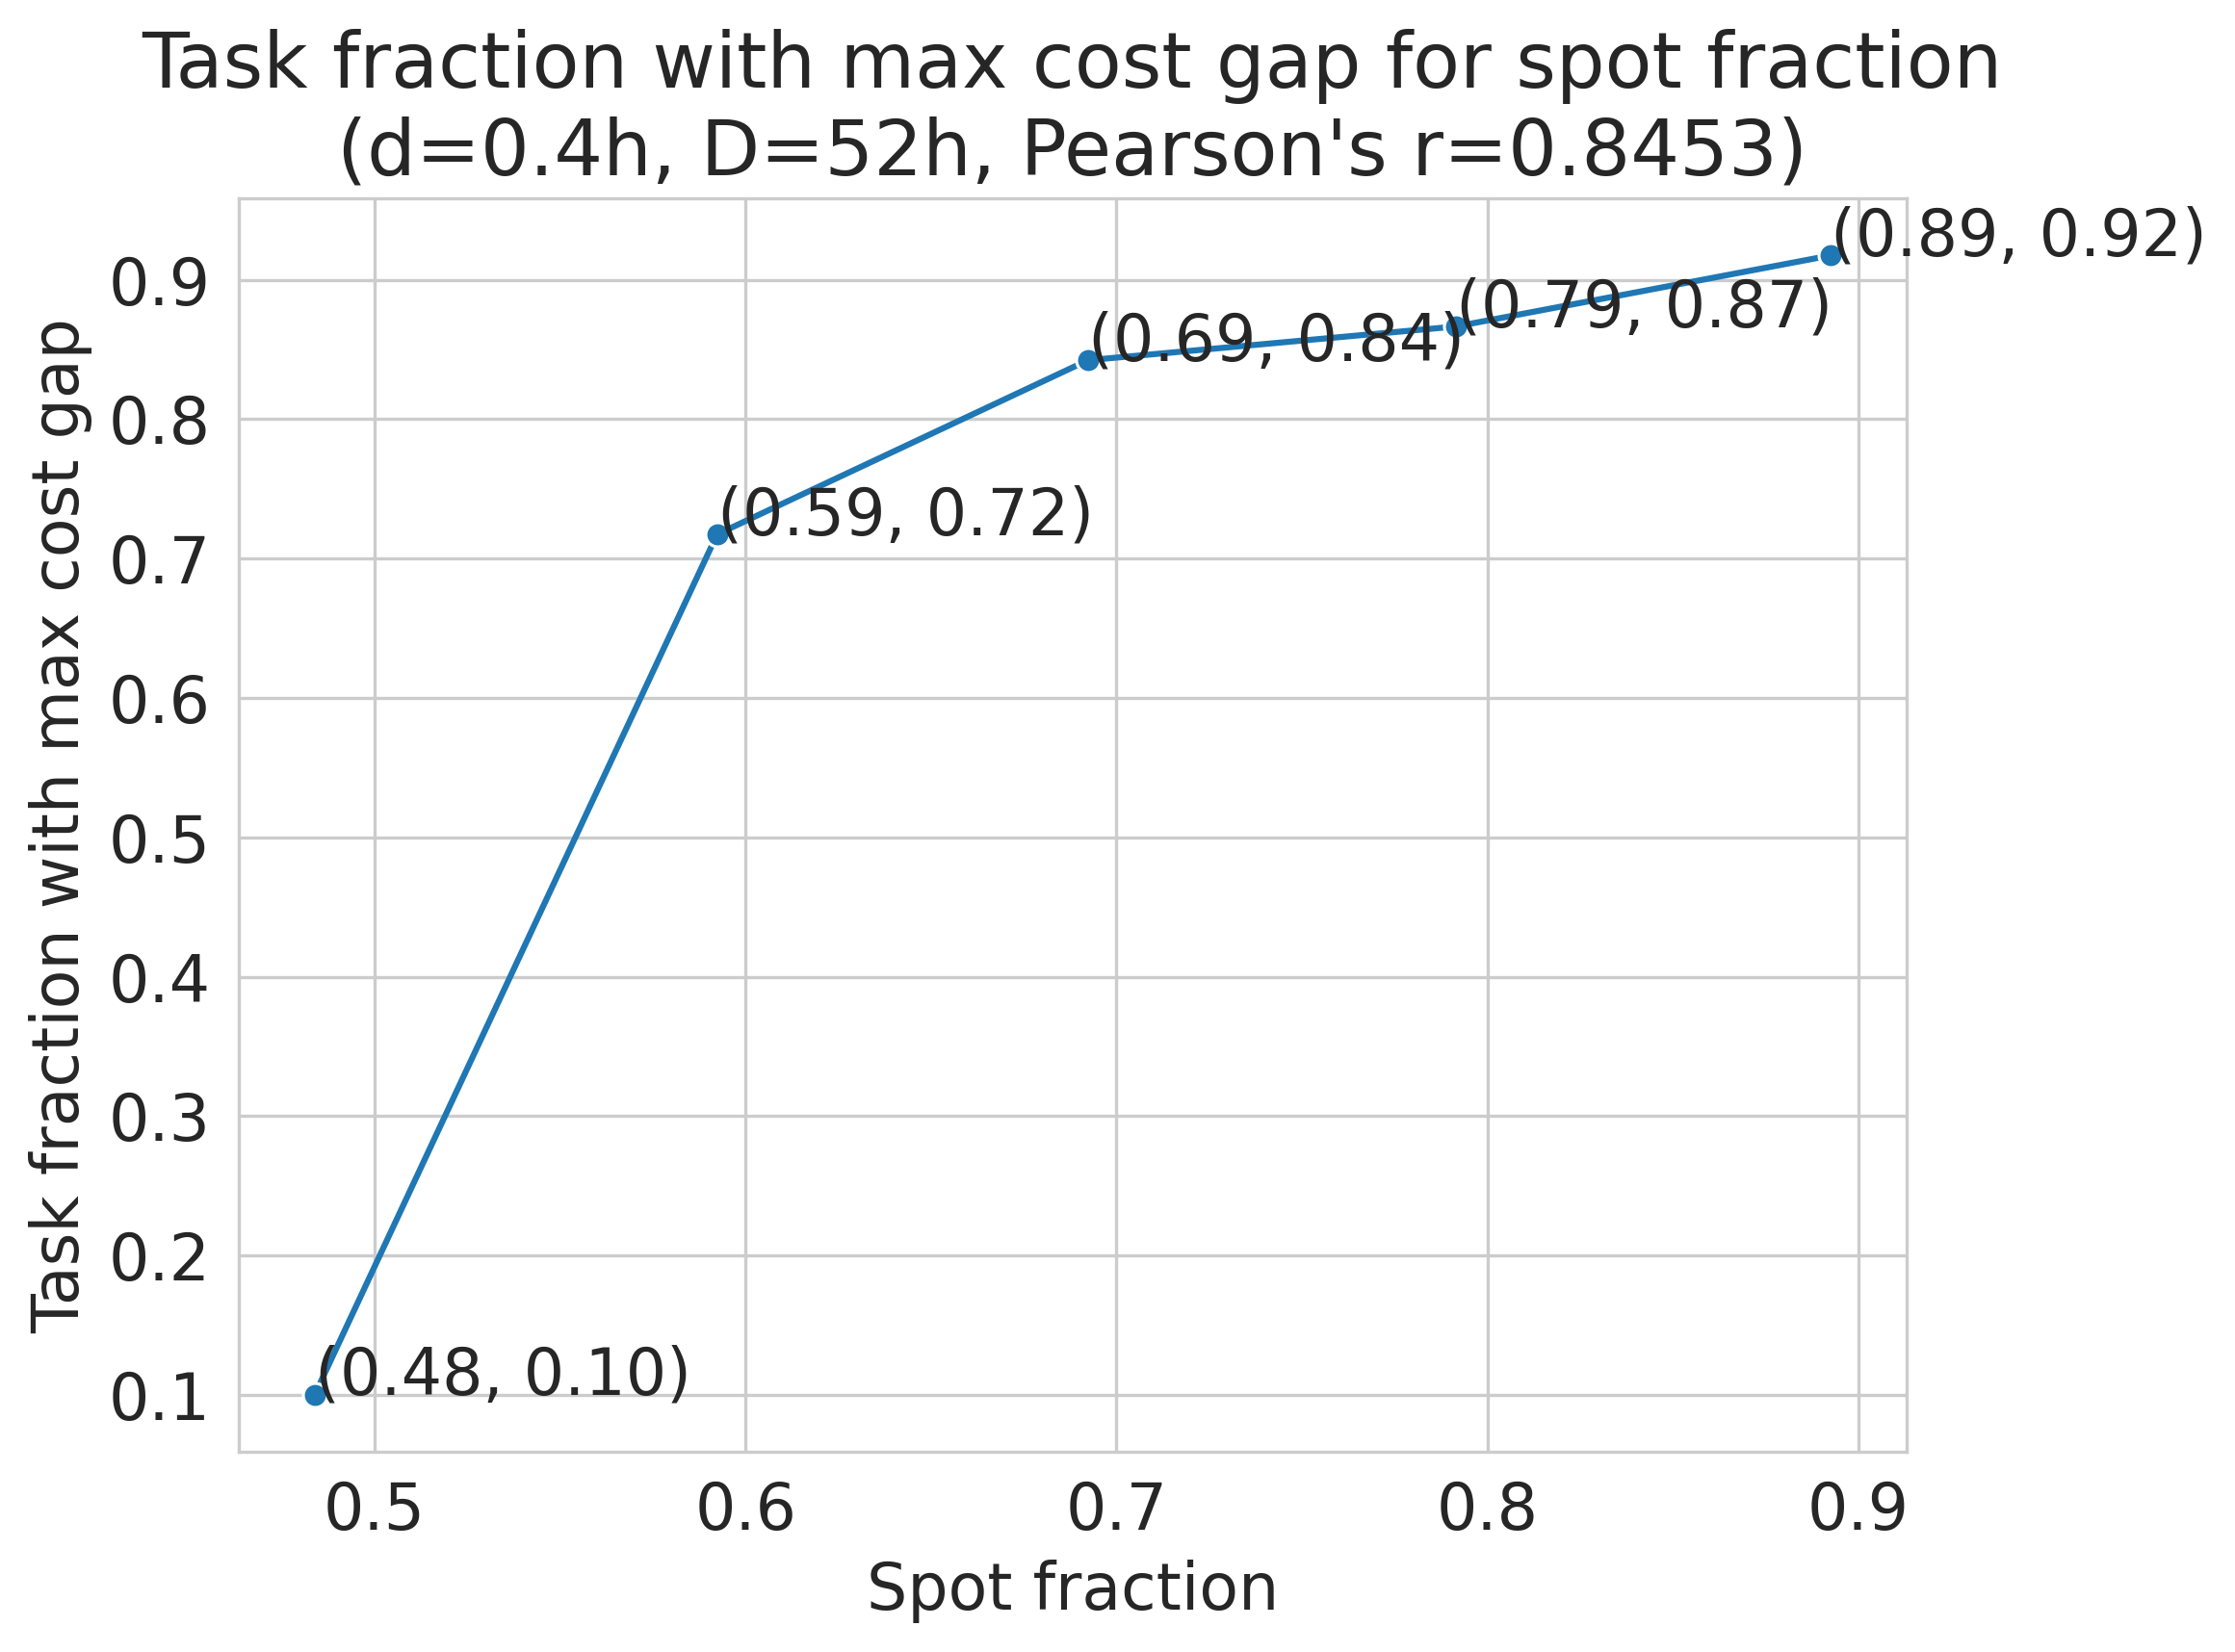

In [ ]:
ORIGINAL_GAP_SECONDS = 600
GAP_SECONDS = 180
ORIGINAL_SPOT_GAPS = 24.5 * ORIGINAL_GAP_SECONDS / GAP_SECONDS
ORIGINAL_WAIT_GAPS = 6.4 * ORIGINAL_GAP_SECONDS / GAP_SECONDS

ORIGIN_SPOT_FRACTION = ORIGINAL_SPOT_GAPS / (ORIGINAL_SPOT_GAPS + ORIGINAL_WAIT_GAPS)

fig = plt.figure(figsize=(8, 6), dpi=300)
ax = fig.add_subplot(111)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16

def task_spot_ratio(row):
    return (row['task_fraction'] - row['spot_fraction'])

max_cost_gap = result_df.loc[result_df.groupby(['spot_fraction'])['cost_gap'].idxmax()]
x = max_cost_gap[max_cost_gap['spot_fraction']>0.5]['spot_fraction']
y = max_cost_gap[max_cost_gap['spot_fraction']>0.5]['task_fraction']
r = np.corrcoef(x, y)[0, 1]
sns.lineplot(x=x,
             y=y,
             ax=ax,
             marker='o')
for row in zip(x,y):
    ax.text(row[0], row[1], f'({row[0]:.2f}, {row[1]:.2f})')
ax.set_xlabel('Spot fraction')
ax.set_ylabel('Task fraction with max cost gap')
ax.set_title(f'Task fraction with max cost gap for spot fraction\n(d={RESTART_OVERHEAD_HOURS}h, D=52h, Pearson\'s r={r:.4f})')

fig.tight_layout()

## (Time Sliced - Optimal) / (Greedy - Optimal)

[  1.     1.55   2.4    8.85   4.05 148.75]
8.051429400000012 1.0
15.582971950000028 1.0
23.729288500000017 1.0
25.809260200000004 1.0
26.920009800000003 1.0
30.49490359999997 1.0
34.30931069999994 1.0
38.868864099999904 1.0
41.85975174999988 1.0
43.54171509999986 1.0
47.92323204999982 1.0
52.65237079999978 1.0
57.62306844999976 1.0
62.26700784999979 1.0
67.48739504999986 1.0
72.37714340000001 1.0
77.43928975000016 1.0
82.07844580000032 1.0
87.18225390000049 1.0
91.9549774500007 1.0
97.07942580000088 1.0
102.3304071000011 1.0
107.38263455000128 1.0
112.47307705000146 1.0
117.10883905000162 1.0
122.3130058000018 1.0
127.31890525000186 1.0
132.38770490000178 1.0
137.4053637000015 1.0
142.38518870000124 1.0
147.19278000000097 1.0
150.1020502500008 1.0
152.1099744000007 1.0
152.28503345000072 1.0
154.2514892000006 1.0
155.96972140000048 1.0
156.4591811500005 1.0
157.13576975000043 1.0
158.70722225000034 1.0
158.96700000000033 2.0
7.10363000000001 2.0
13.525603450000029 1.0
20.2068322500000

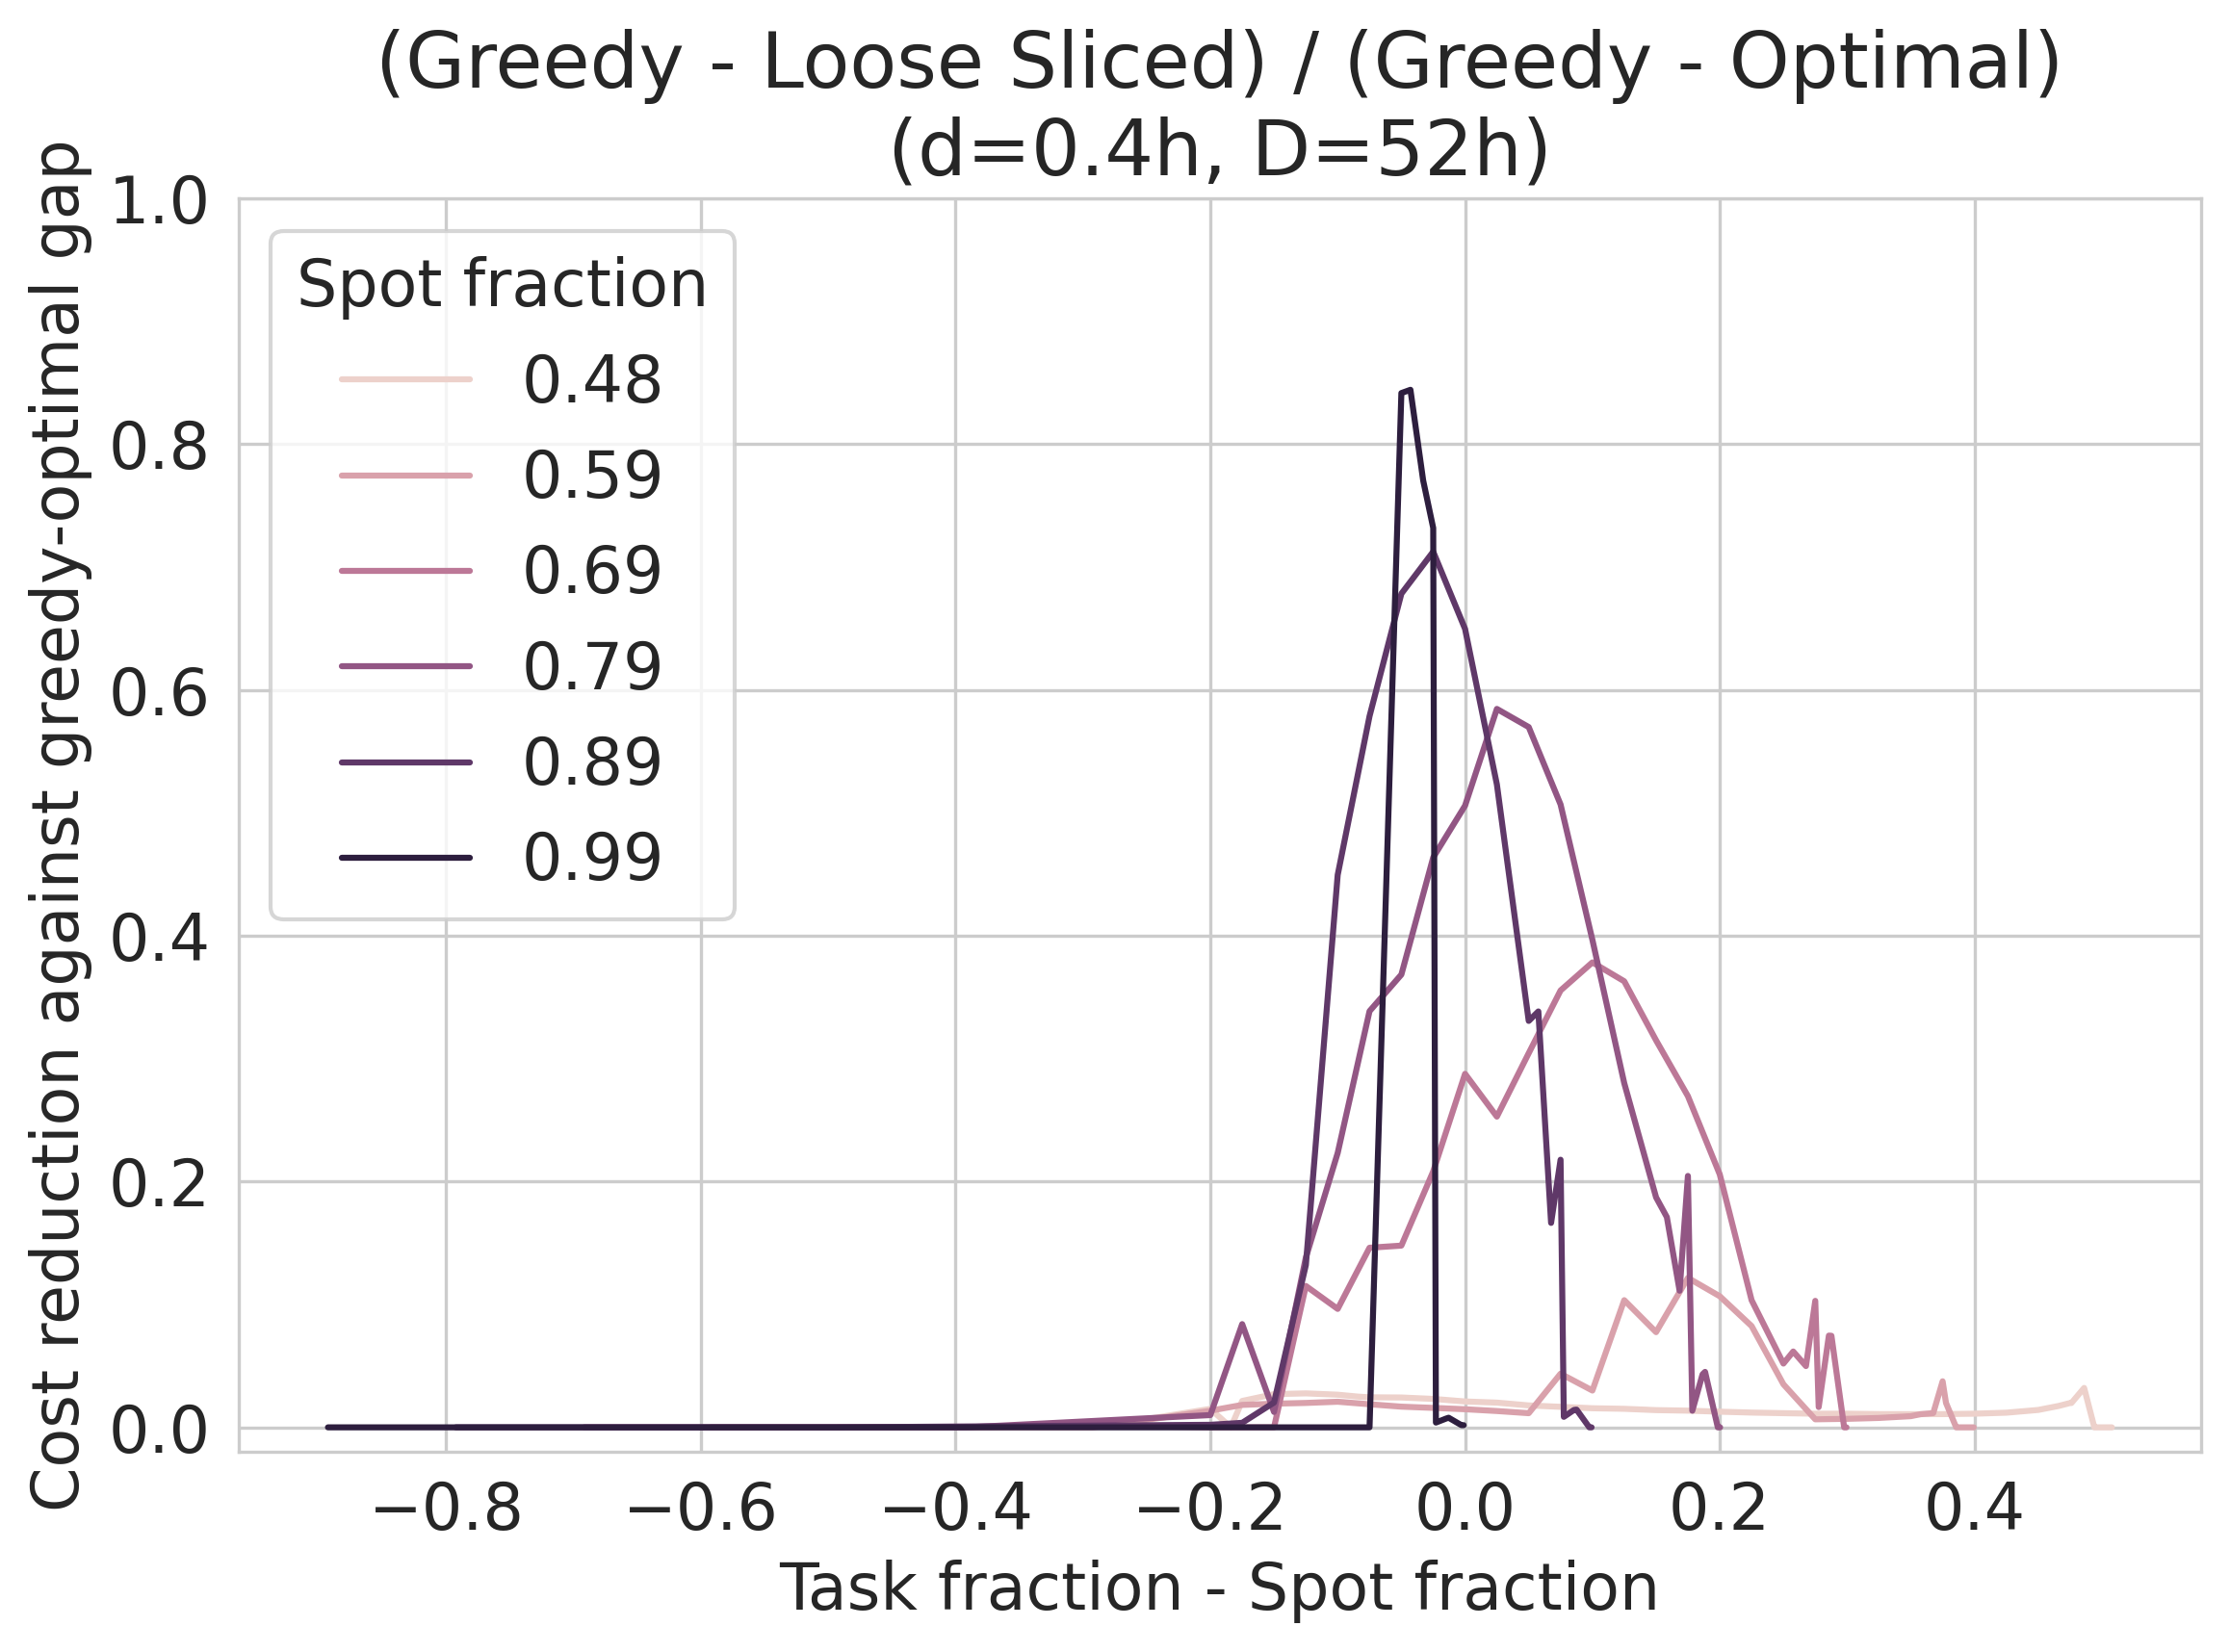

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sky_spot import utils

sns.set_style('whitegrid')

TIME_SLICE_ALGO = 'loose_time_sliced_by_num'


def get_cost_gap(greedy_cost, time_sliced_cost, optimal_cost):
    if (greedy_cost - optimal_cost) < 0.01 * optimal_cost:
        return 0
    res = (greedy_cost - time_sliced_cost) / (greedy_cost - optimal_cost)
    return res


RESTART_OVERHEAD_HOURS = 0.4
df = pd.read_csv(f'../../results/greedy-optimal/restart={RESTART_OVERHEAD_HOURS:.2f}/f_vs_gap_two_exp-180.csv')

time_sliced_df = df[df['strategy'] == TIME_SLICE_ALGO]
print(time_sliced_df['avg_spot_hours'].unique())
idx = time_sliced_df.groupby(['avg_spot_hours', 'task_duration_hours'])['avg_cost'].idxmin()
min_time_sliced = time_sliced_df.loc[idx]

groups = [x for _, x in df.sort_values(by=['avg_spot_hours', 'task_duration_hours']).groupby(['avg_spot_hours', 'task_duration_hours'])]

result_df = pd.DataFrame(
    columns=['spot_fraction', 'task_fraction', 'cost_gap'])

optimal_slices = pd.DataFrame(columns=['avg_spot_hours', 'task_duration_hours', 'num_slices'])

for group in groups:
    avg_spot_hours = group['avg_spot_hours'].iloc[0]
    avg_wait_hours = group['avg_wait_hours'].iloc[0]
    task_duration = group['task_duration_hours'].iloc[0]
    time_sliced_group = min_time_sliced[(min_time_sliced['avg_spot_hours'] == avg_spot_hours) & (min_time_sliced['task_duration_hours'] == task_duration)]
    # print(time_sliced_group)
    spot_fraction = avg_spot_hours / (avg_spot_hours + avg_wait_hours)
    task_fraction = task_duration / 52
    greedy_cost = group[group['strategy'] == 'strawman']['avg_cost']
    if len(greedy_cost) == 0:
        continue
    assert len(greedy_cost) == 1, greedy_cost
    greedy_cost = greedy_cost.iloc[0]
    optimal_cost = group[group['strategy'] == 'ideal_ilp_overhead']['avg_cost']
    assert len(optimal_cost) == 1
    optimal_cost = optimal_cost.iloc[0]
    time_sliced_cost = time_sliced_group['avg_cost']
    if len(time_sliced_cost) == 0:
        continue
    print(time_sliced_group['avg_cost'].values[0], time_sliced_group['num_slices'].values[0])
    assert len(time_sliced_cost) == 1, time_sliced_cost
    time_sliced_cost = time_sliced_cost.iloc[0]

    cost_gap = get_cost_gap(greedy_cost, time_sliced_cost, optimal_cost)
    result_df = pd.concat([
        result_df,
        pd.DataFrame.from_records([{
            'spot_fraction': spot_fraction,
            'task_fraction': task_fraction,
            'cost_gap': cost_gap,
        }])
    ], ignore_index=True)

    optimal_slices = pd.concat([
        optimal_slices, pd.DataFrame.from_records([{
        'spot_fraction': spot_fraction,
        'task_fraction': task_fraction,
        'num_slices': time_sliced_group['num_slices'].values[0],
    }])], ignore_index=True)

# print(result_df)

fig = plt.figure(figsize=(8, 6), dpi=300)
ax = fig.add_subplot(111)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16

def task_spot_ratio(row):
    return (row['task_fraction'] - row['spot_fraction'])
    # return (row['task_fraction'])

x = task_spot_ratio(result_df)
max_cost_gap = result_df.loc[result_df.groupby(['spot_fraction'])['cost_gap'].idxmax()]
# print(max_cost_gap, task_spot_ratio(max_cost_gap))
sns.lineplot(x=x,
             y=result_df['cost_gap'],
             hue=result_df['spot_fraction'],
             ax=ax)
# ax.set_xlabel('Task fraction')
ax.set_xlabel('Task fraction - Spot fraction')
ax.set_ylabel('Cost reduction against greedy-optimal gap')
ax.set_ylim(-0.02, 1.0)
loose_str = 'Loose ' if TIME_SLICE_ALGO == 'loose_time_sliced_by_num' else ''
ax.set_title(f'(Greedy - {loose_str}Sliced) / (Greedy - Optimal)\n(d={RESTART_OVERHEAD_HOURS}h, D=52h)')

ax.legend(title='Spot fraction', loc='upper left')
leg = ax.get_legend()
for t in leg.texts:
    # truncate label text to 4 characters
    t.set_text(f'{float(t.get_text()):.2f}')
fig.tight_layout()

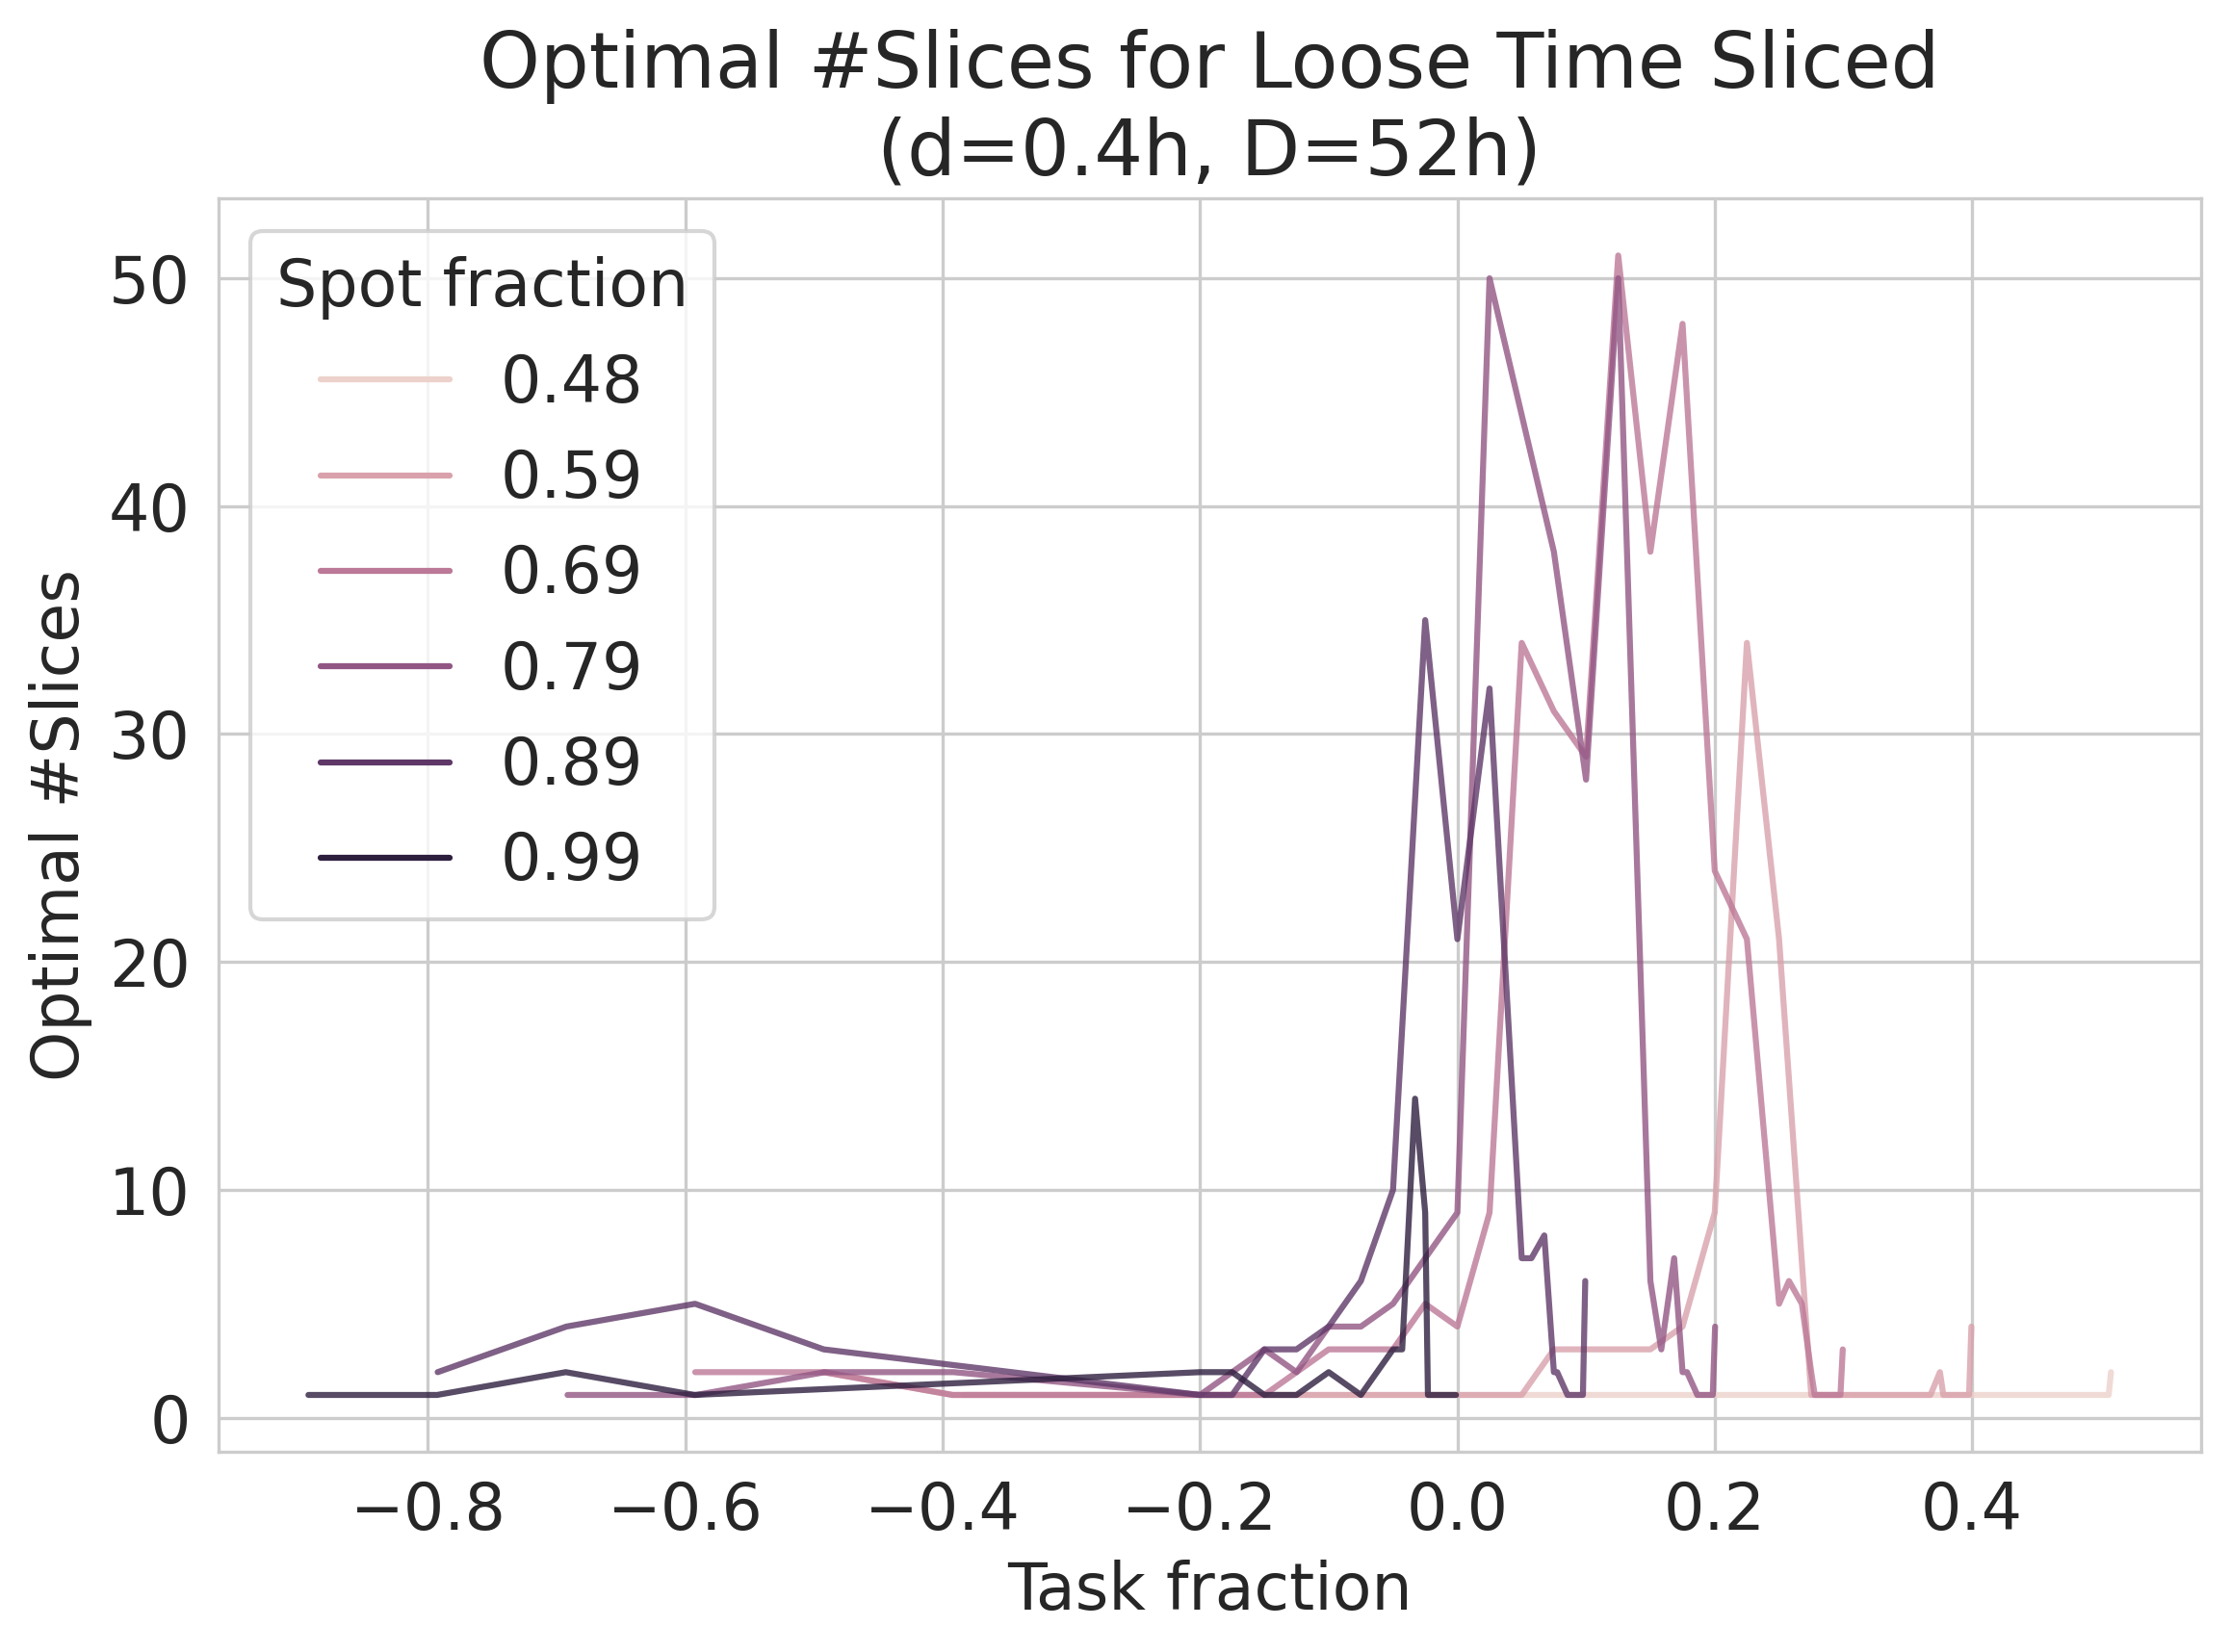

In [6]:
fig = plt.figure(figsize=(8, 6), dpi=300)
ax = fig.add_subplot(111)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16

def task_spot_ratio(row):
    return (row['task_fraction'] - row['spot_fraction'])
    # return (row['task_fraction'])

x = task_spot_ratio(optimal_slices)
# print(max_cost_gap, task_spot_ratio(max_cost_gap))
sns.lineplot(x=x,
             y=optimal_slices['num_slices'],
             hue=optimal_slices['spot_fraction'],
             ax=ax, alpha=0.8)
ax.set_xlabel('Task fraction')
ax.set_ylabel('Optimal #Slices')
loose_str = 'Loose ' if TIME_SLICE_ALGO == 'loose_time_sliced_by_num' else ''
ax.set_title(f'Optimal #Slices for {loose_str}Time Sliced\n(d={RESTART_OVERHEAD_HOURS}h, D=52h)')

ax.legend(title='Spot fraction', loc='upper left')
leg = ax.get_legend()
for t in leg.texts:
    # truncate label text to 4 characters
    t.set_text(f'{float(t.get_text()):.2f}')
fig.tight_layout()